# Data mount from gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Install packages

In [2]:
%%capture
pip install transformers

# Install external packages and modules

In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizerFast, BertForTokenClassification
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import SGD
from transformers import AutoModelForTokenClassification, AutoTokenizer


# Read CSV Data

In [5]:

df = pd.read_csv('/content/drive/MyDrive/Hisab/datasets/Hisab_Ner_Low_Label.csv')
df[100:].head(10)


,text,labels
100,তাঁর দেওয়া তথ্যের ভিত্তিতে গ্রেপ্তার করা হয়ে...,O O O O O O O ORG ORG ORG O B-PERSON I-PERSON O
101,এই মায়াপ্পন আবার ভারতীয় ক্রিকেট বোর্ডের প্রে...,O U-PERSON O ORG ORG ORG O B-PERSON I-PERSON O O
102,এ অবস্থায় শ্রীনিবাসনকে দায়িত্ব থেকে সরিয়ে দ...,O O U-PERSON O O O O O O O
103,নারায়ণগঞ্জ গণজাগরণ মঞ্চের আহ্বায়ক ও নিহত তান...,ORG ORG ORG O O O B-PERSON I-PERSON I-PERSON O...
104,"সরকার মনে করছে, সন্ত্রাসীদের দিয়েই ক্ষমতায় ট...",O O O O O O O O O O O
105,কিন্তু জনগণ সে ক্ষমতায় আপনাদের বেশি দিন রাখবে না,O O O O O O O O O O
106,তাই শামীম ওসমানের মতো খুনিদের গ্রেপ্তার করে জন...,O B-PERSON I-PERSON O O O O O O O O O
107,আজ শুক্রবার সকালে রাজধানীর কেন্দ্রীয় শহীদ মিন...,O O O O GPE GPE GPE O GPE O O B-PERSON I-PERSO...
108,সন্ত্রাস নির্মূল ত্বকী মঞ্চ ওই প্রতীকী গণ-অনশন...,O ORG ORG ORG ORG O O O O O O O O O
109,"রফিউর রাব্বী আরও বলেন, ত্বকী হত্যাকাণ্ডে শামীম...",B-PERSON I-PERSON O O O U-PERSON O B-PERSON I-...


# Initialize Tokenizer











In [6]:
# tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')


In [7]:
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/mbert-bengali-ner")


# Create Dataset Class

In [8]:
label_all_tokens = False

def align_label(texts, labels):
    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]])
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(labels_to_ids[labels[word_idx]] if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids

class DataSequence(torch.utils.data.Dataset):

    def __init__(self, df):

        lb = [i.split() for i in df['labels'].values.tolist()]
        txt = df['text'].values.tolist()
        self.texts = [tokenizer(str(i),
                               padding='max_length', max_length = 512, truncation=True, return_tensors="pt") for i in txt]
        self.labels = [align_label(i,j) for i,j in zip(txt, lb)]

    def __len__(self):

        return len(self.labels)

    def get_batch_data(self, idx):

        return self.texts[idx]

    def get_batch_labels(self, idx):

        return torch.LongTensor(self.labels[idx])

    def __getitem__(self, idx):

        batch_data = self.get_batch_data(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_data, batch_labels

In [9]:
len(df)

3467

# Split Data and Define Unique Labels

In [10]:
# df = df[1000:1020]

labels = [i.split() for i in df['labels'].values.tolist()]
unique_labels = set()

for lb in labels:
        [unique_labels.add(i) for i in lb if i not in unique_labels]
labels_to_ids = {k: v for v, k in enumerate(unique_labels)}
ids_to_labels = {v: k for v, k in enumerate(unique_labels)}

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                            [int(.8 * len(df)), int(.9 * len(df))])

In [11]:
ids_to_labels

{0: 'ORG',
 1: 'U-PERSON',
 2: 'B-PERSON',
 3: 'GPE',
 4: 'I-PERSON',
 5: 'O',
 6: 'LAW'}

In [12]:
unique_labels

{'B-PERSON', 'GPE', 'I-PERSON', 'LAW', 'O', 'ORG', 'U-PERSON'}

# Build Model

In [20]:
class BanglaBertModel(torch.nn.Module):

    def __init__(self):

        super(BanglaBertModel, self).__init__()

        self.banglaBertModel = AutoModelForTokenClassification.from_pretrained("sagorsarker/mbert-bengali-ner", num_labels=len(unique_labels))
        # self.bert = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(unique_labels))

    def forward(self, input_id, mask, label):
        output = self.banglaBertModel(input_ids=input_id, attention_mask=mask, labels=label, return_dict=False)

        return output

# Model Training

In [14]:
from matplotlib import pyplot as plt

In [15]:

training_accuracy = []
training_loss = []
validation_accuracy = []
validation_loss = []

In [ ]:
def train_ner(model, df_train, df_val):

    train_dataset = DataSequence(df_train)
    val_dataset = DataSequence(df_val)

    train_dataloader = DataLoader(train_dataset, num_workers=4, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=BATCH_SIZE)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    optimizer = SGD(model.parameters(), lr=LEARNING_RATE)

    if use_cuda:
        model = model.cuda()

    best_acc = 0
    best_loss = 1000

    for epoch_num in range(EPOCHS):


        total_acc_train = 0
        total_loss_train = 0

        model.train()

        for train_data, train_label in tqdm(train_dataloader):

            train_label = train_label.to(device)
            mask = train_data['attention_mask'].squeeze(1).to(device)
            input_id = train_data['input_ids'].squeeze(1).to(device)

            optimizer.zero_grad()
            loss, logits = model(input_id, mask, train_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][train_label[i] != -100]
              label_clean = train_label[i][train_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_train += acc
              total_loss_train += loss.item()

            loss.backward()
            optimizer.step()

        model.eval()

        total_acc_val = 0
        total_loss_val = 0

        for val_data, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_data['attention_mask'].squeeze(1).to(device)
            input_id = val_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, val_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][val_label[i] != -100]
              label_clean = val_label[i][val_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_val += acc
              total_loss_val += loss.item()

        val_accuracy = total_acc_val / len(df_val)

        val_loss = total_loss_val / len(df_val)

        print(
            f'Epochs: {epoch_num + 1} | Loss: {total_loss_train / len(df_train): .3f} | Accuracy: {total_acc_train / len(df_train): .3f} | Val_Loss: {total_loss_val / len(df_val): .3f} | Accuracy: {total_acc_val / len(df_val): .3f}')

        # training_accuracy.append(total_acc_train / len(df_train))
        # training_loss.append(total_loss_train / len(df_train))
        # validation_accuracy.append(total_acc_val / len(df_val))
        # validation_loss.append(total_loss_val / len(df_val))


    torch.save(model, '/content/drive/MyDrive/Hisab/hisab_ner.pth')

LEARNING_RATE = 5e-3
EPOCHS = 8
BATCH_SIZE = 2

model = BanglaBertModel()
train_ner(model, df_train, df_val)

 79%|███████▊  | 1090/1387 [03:18<00:53,  5.53it/s]

# Accuracy and loss graph for train and val

<function matplotlib.pyplot.show(close=None, block=None)>

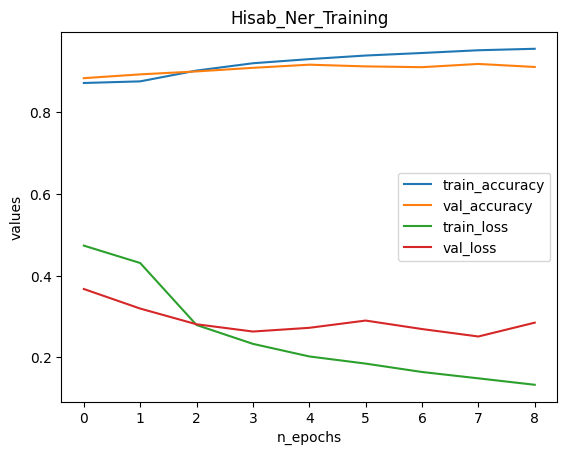

In [50]:
plt.plot(training_accuracy, label='train_accuracy')
plt.plot(validation_accuracy,label='val_accuracy')
plt.plot(training_loss, label='train_loss')
plt.plot(validation_loss,label='val_loss')
plt.title('Hisab_Ner_Training')
plt.xlabel('n_epochs')
plt.ylabel('values')

plt.legend()
plt.savefig('hisab_ner.png')
plt.show

# Evaluate Model

In [ ]:
def evaluate(model, df_test):

    test_dataset = DataSequence(df_test)

    test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0.0

    for test_data, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_data['attention_mask'].squeeze(1).to(device)

            input_id = test_data['input_ids'].squeeze(1).to(device)

            loss, logits = model(input_id, mask, test_label)

            for i in range(logits.shape[0]):

              logits_clean = logits[i][test_label[i] != -100]
              label_clean = test_label[i][test_label[i] != -100]

              predictions = logits_clean.argmax(dim=1)
              acc = (predictions == label_clean).float().mean()
              total_acc_test += acc

    val_accuracy = total_acc_test / len(df_test)
    print(f'Test Accuracy: {total_acc_test / len(df_test): .3f}')


evaluate(model, df_test)

Test Accuracy:  0.943


# Predict One Sentence

In [51]:
def align_word_ids(texts):

    tokenized_inputs = tokenizer(texts, padding='max_length', max_length=512, truncation=True)

    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []

    for word_idx in word_ids:

        if word_idx is None:
            label_ids.append(-100)

        elif word_idx != previous_word_idx:
            try:
                label_ids.append(1)
            except:
                label_ids.append(-100)
        else:
            try:
                label_ids.append(1 if label_all_tokens else -100)
            except:
                label_ids.append(-100)
        previous_word_idx = word_idx

    return label_ids


def predict(model, sentence):


    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        # model = model.cuda()
        model = torch.load('/content/drive/MyDrive/Hisab/hisab_ner.pth')

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)
    label_ids = torch.Tensor(align_word_ids(sentence)).unsqueeze(0).to(device)

    logits = model(input_id, mask, None)
    logits_clean = logits[0][label_ids != -100]

    predictions = logits_clean.argmax(dim=1).tolist()
    prediction_label = [ids_to_labels[i] for i in predictions]
    sentence = sentence.split(' ')
    ner_result = ''
    if len(sentence)==len(prediction_label):
        for idx in range(len(prediction_label)):
            # if prediction_label[idx] == 'U-PERSON':
            #     ner_result += sentence[idx] + ','
            if prediction_label[idx] == 'B-PERSON':
                ner_result += sentence[idx]
            elif prediction_label[idx] == 'I-PERSON':
                ner_result += ' ' + sentence[idx]
        print(ner_result+'\n')
    else:
        print('------------------------------------------------------------------------\n\nInput Text: {}'.format(sentence))
        print('Predicted labels: {}\n'.format(prediction_label))




# Infer on example sentence

In [55]:
sentence = 'আব্দুর রহিম নামের কাস্টমারকে একশ টাকা বাকি দিলাম'

In [56]:
# sentence = 'আমি বাড়িতে গিয়ে শাহেদ মামুনকে দাওয়াত দিব।'

# Inference Result

In [57]:
predict(model, sentence)

['B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O']
